In [4]:
from __init__ import DATASET_PATH


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import xgboost as xgb

from textwrap import wrap

from main.constants import PROLACTIN, VITAMINE_D, IGF, PCO, CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [2]:
dataset_file_path = DATASET_PATH
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,elevated DHT,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mmol/l,CHOL>200,HDL mmol/l,HDL<50,LDL mmol/l,LDL>135,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,SHBG>110,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age
554,1,167.0,40.12,8.140000,67.5,173.0,22.553376,109.0,74.0,0.0,76.5,0.0,85.0,0.900000,1.0,1.0,0.442197,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,18.0,1.0,1.0,1.0,4.5600,4.920,9.4800,0.0,1.0,18.7000,8.75,27.4500,1.0,4.95,2.71,1.51,0.57,0.13,0.03,54.8,30.5,11.5,2.6,0.6,4.66,12.8,38.3,2.992188,82.2,27.5,33.4,13.8,236.0,13.5,11.1,34.3,47.676768,0.047034,156.291391,2.649123,1.794702,0.305051,0.026263,144.0,4.91,9.77,3.06,0.89,0.3,20.0,26.0,0.51,5.37888,1.0,2.40498,0.0,2.503248,0.0,1.07255,1.040860,1.021505,0.808293,31.132948,19.842175,4.515607,0.009241,342.0,52.0,NaN,NaN,7.0,88.0,139.0,5.45,54.88,1.184198,7.80,0.373012,0.98,5.320,13.86,12.0,278.0,5.4,23.8,4.407407,315.0,466.0,3.2,0.922190,0.071588,46.628125,41.97,286.0,167.0,43.0,44.7,0.0,7.19,20.02,5.5,21.0,5.91,3.71,532.0,0.006015,0.541455,27.0
491,1,345.0,17.60,2.523810,75.0,158.0,30.043262,136.0,79.0,0.0,87.0,0.0,98.0,0.887755,1.0,1.0,0.550633,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,7.5240,4.080,11.6040,1.0,1.0,10.0832,6.47,16.5532,0.0,5.18,2.62,1.90,0.53,0.11,0.02,50.6,36.7,10.2,2.1,0.4,4.66,13.3,41.7,3.135338,89.5,28.5,31.9,12.9,256.0,11.3,10.2,25.8,49.420849,0.039844,134.736842,3.584906,1.378947,0.366795,0.021236,143.0,3.78,9.60,3.78,0.74,3.6,23.0,20.0,0.25,3.64626,0.0,1.55160,0.0,1.781754,0.0,0.65482,1.148333,0.966667,0.737991,44.025316,18.989780,4.352417,-0.014723,289.0,69.0,357.0,19.0,56.0,104.0,112.0,14.15,67.56,3.633580,2.99,0.315678,2.85,6.070,18.26,20.0,13.0,3.9,8.4,2.153846,1040.0,425.0,1.4,0.403458,0.066667,76.835714,29.05,594.0,137.0,31.0,21.0,0.0,6.63,113.10,5.4,12.0,5.02,3.81,452.0,0

### Continuous and Categorical attributes

In [8]:
# categorical_attributes = [
#     'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'Hypertension', 'WC>88', 'WHR>0,85 (WHO)', 'WHR>0,8 (NIDDK)', 'WHTR>0,5', 
#     'overweight/obesity 0-normal/low, 1-overweight, 2-obesity', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
#     'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'hyperandrogenism', 'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'chronic thyroiditis',
#     'follicules >12', 'hyperlipidemia', 'elevated LDL and TG', 'CHOL>200', 'HDL<50', 'LDL>135', 'TG>150', 'Impaired Fasting Glucose ', 'Impaired Glucose Tolerance', 
#     'month of birth', 'quarter of the year',
#     ]

# continuous_attributes = list(df.columns.drop(categorical_attributes))


# df[categorical_attributes] = df[categorical_attributes].astype('Int8')
# df[continuous_attributes] = df[continuous_attributes].astype('Float64')

# Imputers pipeline

Best preprocessing techniques for vitamine D:
- PowerTransformer
- IterativeImputer
- Advanced one hot encoder
- Lasso > DecisionTreeRegressor

In [5]:
def get_continuous_attributes_except(attribute):
    remaining_attributes = CONTINUOUS_ATTRIBUTES.copy()
    remaining_attributes.remove(attribute)
    return remaining_attributes


class Scaler:
    def __init__(self, scaling_method, attributes_to_scale):
        self.scaling_method = scaling_method
        self.attributes_to_scale = attributes_to_scale
        self.scaler = None

    def fit(self, X, y=None):
        self.scaler = ColumnTransformer(
            transformers=[
                ('scaler', self.scaling_method, self.attributes_to_scale)
            ],
            # so that the categorical columns remain unchanged
            remainder='passthrough',
            # so it doesn't rename the columns
            verbose_feature_names_out=False,
            )
        self.scaler.set_output(transform='pandas')
        self.scaler.fit(X)


    def fit_transform(self, X, y=None):
        self.scaler = ColumnTransformer(
            transformers=[
                ('scaler', self.scaling_method, self.attributes_to_scale)
            ],
            # so that the categorical columns remain unchanged
            remainder='passthrough',
            # so it doesn't rename the columns
            verbose_feature_names_out=False,
            )
        self.scaler.set_output(transform='pandas')
        return self.scaler.fit_transform(X)
    
    def transform(self, X, y=None):
        if not self.scaler:
            return RuntimeError('Call fit_tranform() method first')
        return self.scaler.transform(X)


In [6]:
class Imputer:
    def __init__(self, imputing_method_continuous, imputing_methohd_categorical, continuous_attributes, categorical_attributes):
        self.imputing_method_continuous = imputing_method_continuous
        self.imputing_method_categorical = imputing_methohd_categorical
        self.continuous_attributes = continuous_attributes
        self.categorical_attributes = categorical_attributes
        self.imputer_continuous = None
        self.imputer_categorical = None

    def fit(self, X, y=None):
        self.imputer_continuous = self.imputing_method_continuous
        self.imputer_continuous.set_output(transform='pandas')
        self.imputer_continuous.fit(X[self.continuous_attributes])

        self.imputer_categorical = self.imputing_method_categorical
        self.imputer_categorical.set_output(transform='pandas')
        self.imputer_categorical.fit(X[self.categorical_attributes]).astype('Int8')

    def fit_transform(self, X, y=None):
        self.imputer_continuous = self.imputing_method_continuous
        self.imputer_continuous.set_output(transform='pandas')
        X_continuous_imputed = self.imputer_continuous.fit_transform(X[self.continuous_attributes])

        self.imputer_categorical = self.imputing_method_categorical
        self.imputer_categorical.set_output(transform='pandas')
        X_categorical_imputed = self.imputer_categorical.fit_transform(X[self.categorical_attributes]).astype('Int8')

        return pd.concat([X_continuous_imputed, X_categorical_imputed], axis=1)
    
    def transform(self, X, y=None):
        if not self.imputer_continuous or not self.imputer_categorical:
            return RuntimeError('Call fit_tranform() method first')
        X_continuous_imputed = self.imputer_continuous.transform(X[self.continuous_attributes])
        X_categorical_imputed = self.imputer_categorical.transform(X[self.categorical_attributes]).astype('Int8')

        return pd.concat([X_continuous_imputed, X_categorical_imputed], axis=1)

In [35]:
def run_imputers_comparison_pipeline():
    model_scores_df = pd.DataFrame(columns=['imputer', 'train_mae', 'test_mae', "test_mse", "test_rmse"])
    
    # TODO: drop some random rows


    # scaling
    attributes_to_scale = CONTINUOUS_ATTRIBUTES
    scaler = Scaler(PowerTransformer(), attributes_to_scale)

    # missing data imputation
    continuous_imputers = {
         'LinearRegression': IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median'),
         'RF 10': IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median', estimator=RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)),
         'RF 50': IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median', estimator=RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)),
         'RF 100': IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median', estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    }

    for continuous_imputer_name, continuous_imputer in continuous_imputers.items():
        imputer = Imputer(IterativeImputer(continuous_imputer, KNNImputer(n_neighbors=1), attributes_to_scale, categorical_attributes))

        # one hot encoding
        one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True) 

    # prediction
    for model in [DecisionTreeRegressor(max_depth=5, random_state=42), Lasso(), Ridge()]:
            
            pipeline = make_pipeline(scaler, imputer, one_hot_encoder, model)
            # TODO: repeat spowrotem na 3
            rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

            for train, test in rkf.split(X_train, y_train):
                X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
                X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]
                print('1')

                pipeline.fit(X_train_fold, y_train_fold)
                y_train_fold_pred = pipeline.predict(X_train_fold)

                y_test_fold_pred = pipeline.predict(X_test_fold)
                
                train_mse = round(mean_squared_error(y_train_fold, y_train_fold_pred), 3)

                test_mse = round(mean_squared_error(y_test_fold, y_test_fold_pred), 3)
                test_mae = round(mean_absolute_error(y_test_fold, y_test_fold_pred), 3)
                test_rmse = round(root_mean_squared_error(y_test_fold, y_test_fold_pred), 3)

                # validation
                # pipeline.fit(X_train, y_train)
                # y_val_pred = pipeline.predict(X_val)
                # val_mae = round(mean_absolute_error(y_val. y_val_pred), 3)

                model_scores_df.loc[len(model_scores_df)] = [str(model), train_mse, test_mse, test_mae, test_rmse]


    return model_scores_df


vit_d_model_scores_df = run_model_pipeline(VITAMINE_D)
vit_d_model_scores_df

1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


In [31]:
vit_d_model_scores_df.groupby('model').mean()

,train_mse,test_mse,test_mae,test_rmse
model,,,,
"DecisionTreeRegressor(max_depth=5, random_state=42)",65.4658,181.5436,10.4520,13.4476
Lasso(),118.2466,128.2492,8.8162,11.3124


In [48]:
vit_d_model_scores_df

,model,train_mse,val_mse,val_mae,val_rmse
0,"DecisionTreeRegressor(max_depth=5, random_stat...",60.096,193.035,10.513,13.894
1,"DecisionTreeRegressor(max_depth=5, random_stat...",74.899,195.416,11.168,13.979
2,"DecisionTreeRegressor(max_depth=5, random_stat...",55.390,208.623,11.706,14.444
3,"DecisionTreeRegressor(max_depth=5, random_stat...",72.597,151.446,9.591,12.306
4,"DecisionTreeRegressor(max_depth=5, random_stat...",64.347,184.868,10.427,13.597
5,"DecisionTreeRegressor(max_depth=5, random_stat...",77.889,193.740,10.734,13.919
6,"DecisionTreeRegressor(max_depth=5, random_stat...",60.866,206.816,10.845,14.381
7,"DecisionTreeRegressor(max_depth=5, random_stat...",58.824,250.895,11.741,15.840
8,"DecisionTreeRegressor(max_depth=5, random_stat...",57.009,209.356,11.096,14.469
9,"DecisionTreeRegressor(max_depth=5, random_stat...",77.928,179.642,10.349,13.403


In [49]:
#  with a default iterativeimputer linearRegression estimator
vit_d_model_scores_df.groupby('model').mean()

,train_mse,val_mse,val_mae,val_rmse
model,,,,
"DecisionTreeRegressor(max_depth=5, random_state=42)",67.466933,200.392800,10.8804,14.1186
Lasso(),118.070800,128.467533,8.8336,11.2932


### Hyperparameter tuning

Dla każdego z modeli przetestować różne parametry i stworzyć wykresy dla każdego parametru:
- np alpha parameter (x) vs mae (y)
- 

#### Lasso

In [37]:
def hyperparameter_tuning(target_attribute, model, param_grid):
    # model_scores_df = pd.DataFrame(columns=['model', 'alpha', 'train_mae', "test_mae", 'test_mse', "test_rmse"])
    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])
    
    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # scaling
    attributes_to_scale = get_continuous_attributes_except(target_attribute)
    scaler = Scaler(PowerTransformer(), attributes_to_scale)

    # missing data imputation
    imputer = Imputer(IterativeImputer(max_iter=40, tol=0.01, initial_strategy='median'),
                                        # TODO: experiment with different estimators and increase max_iter
                                    #    estimator=RandomForestRegressor(n_estimators=10,
                                    #                                     max_depth=10,
                                    #                                     bootstrap=True,
                                    #                                     max_samples=0.5,
                                    #                                     n_jobs=2,
                                    #                                     random_state=42)),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    categorical_attributes)

    # one hot encoding
    one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True) # TODO: try with advanced encoding 

    pipeline = Pipeline([('scaler', scaler), ('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True).fit(X_train, y_train)

    return grid_search.cv_results_


model = Lasso()

param_grid = {
    "model__alpha": 10.0 ** np.arange(-1, 3),
    #  "model__alpha": 10.0 ** np.arange(-5, 6),
              }

vit_d_model_hyperparam_tuning_df = hyperparameter_tuning(VITAMINE_D, model, param_grid)
vit_d_model_hyperparam_tuning_df


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.118e+00, tolerance: 4.989e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\

{'mean_fit_time': array([109.16592369,  62.32950935,  62.33647876,  66.22161074]),
 'std_fit_time': array([76.382824  ,  0.39626516,  0.23494729,  6.14108938]),
 'mean_score_time': array([0.3219862 , 0.19005113, 0.16095967, 0.20741949]),
 'std_score_time': array([0.21601786, 0.04149761, 0.01517507, 0.06198451]),
 'param_model__alpha': masked_array(data=[0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__alpha': 0.1},
  {'model__alpha': 1.0},
  {'model__alpha': 10.0},
  {'model__alpha': 100.0}],
 'split0_test_score': array([-8.84589879, -8.66739971, -9.51911856, -9.51911856]),
 'split1_test_score': array([-10.01262553,  -9.01997728,  -9.64363749,  -9.64363749]),
 'split2_test_score': array([-9.92383366, -8.69328409, -8.97653631, -8.97653631]),
 'split3_test_score': array([-9.17515054, -8.57576041, -8.83496604, -8.83496604]),
 'split4_test_score': array([-9.40441489, -8.93567443, -9.28146224, -

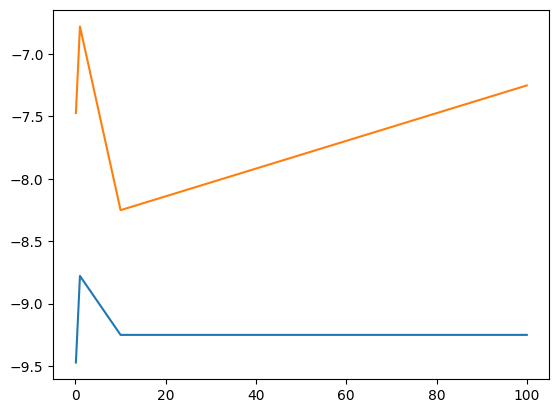

In [30]:
# alphas = grid_search['param_model__alpha']

# mean_test_score = grid_search['mean_test_score']
# mean_train_score = grid_search['mean_train_score']


alphas = [0.1, 1, 10, 100]
mean_test_score = [-9.47238468, -8.77841918, -9.25114413, -9.25114413]
mean_train_score = [-7.47238468, -6.77841918, -8.25114413, -7.25114413]

results_df = pd.DataFrame({'alpha': alphas, 'mean_test_score': mean_test_score, 'mean_train_score': mean_train_score})


plt.plot(alphas, mean_test_score)
plt.plot(alphas, mean_train_score)


<Axes: xlabel='alpha', ylabel='value'>

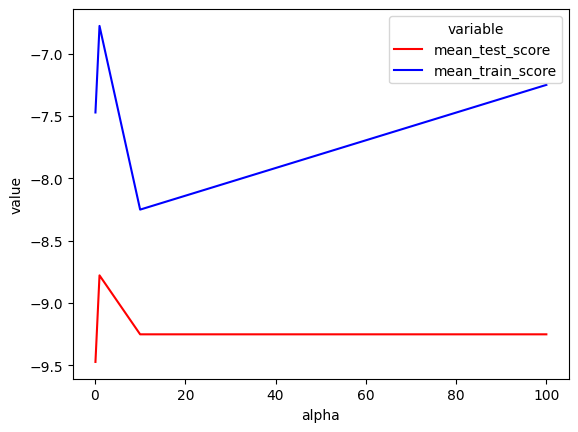

In [33]:
sns.lineplot(x='alpha', y='value', hue='variable', 
             data=pd.melt(results_df, ['alpha']),
             palette=['red', 'blue'])

In [ ]:
# fajny wykres przedstawiający liczbę zmiennych - może zbyt duży na naszą liczbę zmiennych

coefs=[]
alphas=2**np.arange(5,-10,-.1)
for alpha in alphas:
    ridge= Ridge(alpha=alpha, max_iter=100000).fit(X_train, y_train)
    coefs.append(ridge.coef_)
coefs=np.array(coefs)

#plot results
N,M=X_train.shape
plt.figure(figsize=(10,7))
for i in range(M):
    plt.plot(alphas, coefs[:,i], label="Var %d" % (i+1))
plt.axvline(x = 0.1, color = 'b', label = 'best Alpha')
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

# Model selection for IGF

# Model selection for prolactin

### Feature selection

In [28]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_preprocessed, y_train)
importances = np.abs(lasso.coef_)

In [29]:

selector = SelectFromModel(model, threshold=0.1)
selector.fit(X_train_preprocessed, y_train)
selected_features = X_train_preprocessed.columns[selector.get_support()]
selected_features

Index(['age'], dtype='object')

In [30]:

result = permutation_importance(model, X_test_preprocessed, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# # Associate each importance value with its corresponding feature name
feature_importances = dict(zip(X_test_preprocessed.columns, importances))

# Print the columns together with their importances
for feature, importance in feature_importances.items():
    if importance != 0:
        print(f"{feature}: {importance}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- birth_month_-0.2
- birth_month_-0.4
- birth_month_-0.6
- birth_month_-0.8
- birth_month_-1.0
- ...
Feature names seen at fit time, yet now missing:
- birth_month_-0.16666666666666666
- birth_month_-0.3333333333333333
- birth_month_-0.5
- birth_month_-0.6666666666666666
- birth_month_-0.8333333333333334
- ...


In [31]:
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train_preprocessed, y_train)
importances = rfe.ranking_

feature_importances = dict(zip(X_test_preprocessed.columns, importances))

sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1])

# Print the columns together with their importances
for feature, importance in sorted_feature_importances:
    if importance != 0:
        print(f"{feature}: {importance}")

WHR (Waist/Hip ratio): 1
% lymphocytes : 1
P-LCR %: 1
HOMA: 1
age: 1
ALT U/l: 2
hematocrit [%]: 3
PLT x10^3/ul: 4
Estradiol pg/ml: 5
LDL mmol/l: 6
MCH pg: 7
glucose  120 mg/dl: 8
Dihydrotestosterone pg/ml (N<368): 9
MPV fl: 10
CRP mg/l: 11
LH/FSH: 12
FT4 pmol/l: 13
FT3 pmol/l: 14
VAI - Visceral adiposity index: 15
ovaries volume - total: 16
neutrophil x10^3/ul: 17
RDW-CV %: 18
Matsuda: 19
TIBC: 20
Anty-TG IU/ml: 21
cortisol nmol/l  8:00: 22
TSH mIU/L: 23
T/SHBG: 24
thyroid volume: 25
CHOL mg/dl : 26
overweight_1.0: 27
FG score (Ferriman-Gallway score - stopień androgenizacji): 28
Hemoglobin [g/dl]: 29
lymphocytes x10^3/ul: 30
Anty-TPO IU/ml: 31
AST U/l: 32
Vole of the Right Ovary: 33
DHEA-S ug/dl: 34
nodules_0.0: 35
T (ng/ml): 36
potassium mmol/l: 37
SHBG nmol/l: 38
Atherogenic index (AI) (LDL-C/HDL-C) : 39
Volume of the thyroid  Left Lobe: 40
Parathormone pg/ml: 41
BAI - Body adiposity index: 42
% neutrophil : 43
QUICKI (N<0,357): 44
glucose 0 mg/dl: 45
birth_month_0.6: 46
Testosteron

In [32]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_preprocessed.shape[1]):

    print(f"{f + 1}. Feature '{X_train_preprocessed.columns[indices[f]]}' ({importances[indices[f]]})")

Feature ranking:
1. Feature 'age' (0.11558109256072505)
2. Feature '% lymphocytes ' (0.037067424059781806)
3. Feature '17-OH-progesterone ng/ml' (0.02265471763561137)
4. Feature 'insulin 0 uU/ml' (0.02005921061817757)
5. Feature 'ALT U/l' (0.020031333707779757)
6. Feature 'TIBC' (0.018341271049474084)
7. Feature 'P-LCR %' (0.0180263764801652)
8. Feature 'DHEA-S ug/dl' (0.017381523781329275)
9. Feature 'E(pg/ml)/T(ng/ml)/' (0.013925019525298177)
10. Feature 'Dihydrotestosterone pg/ml (N<368)' (0.01381382592287395)
11. Feature 'FT3 pmol/l' (0.013211499351731826)
12. Feature 'MPV fl' (0.013196172022832464)
13. Feature 'QUICKI (N<0,357)' (0.012496564375672798)
14. Feature 'ferritin ng/ml' (0.011887067391901414)
15. Feature 'Hemoglobin [g/dl]' (0.011773180214576847)
16. Feature 'WHTR (Waist/Height Ratio)' (0.010941850797454569)
17. Feature 'neutrophil x10^3/ul' (0.01090754824336664)
18. Feature 'phosphorus mg/dl' (0.010880616821887323)
19. Feature 'SHBG nmol/l' (0.010875881110953065)
20. Fe

## Training pipeline

### Scaler

### Imputer

In [33]:
class MissingDataImputer:
    def __init__(self, 
                columns_to_drop_rows_if_missing_value=[],
                columns_to_impute_with_median=[],
                columns_to_impute_with_knn=[],
                columns_to_drop=[]):
        self.columns_to_drop_rows_if_missing_value = columns_to_drop_rows_if_missing_value
        self.columns_to_impute_with_median = columns_to_impute_with_median
        self.columns_to_impute_with_knn = columns_to_impute_with_knn
        self.columns_to_drop = columns_to_drop

    def impute(self, X, y):
        X, y = X.copy(), y.copy()

        # Drop rows for which the values in specified columns are missing
        if self.columns_to_drop_rows_if_missing_value:
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
            X = X.dropna(subset=self.columns_to_drop_rows_if_missing_value)
            y = y.loc[X.index] # leave only the relevant rows in y

        # Impute specified columns with median
        if self.columns_to_impute_with_median:
            #  TODO: fit transform only on the training set and only transform on the test set
            median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            X[self.columns_to_impute_with_median] = median_imputer.fit_transform(X[self.columns_to_impute_with_median])

        # Impute specified columns with knn
        if self.columns_to_impute_with_knn:
            #  TODO: fit transform only on the training set and only transform on the test set
            knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
            X[self.columns_to_impute_with_knn] = knn_imputer.fit_transform(X[self.columns_to_impute_with_knn])

        # Drop specified columns
        if self.columns_to_drop:
            X = X.drop(columns=self.columns_to_drop)
        
        return X, y